In [268]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
import pandas as pd
import numpy as np

def rmMissing(df: pd.DataFrame, header: list):
    idx = []
    for i in range(1,len(df.columns)):
        if ((df[df.columns[i]].dtypes == "float64") or (df.columns[i]=="traffic_load_man") or (df.columns[i]=="traffic_int_road")):
            if not (df.columns[i]=="bread_intake" or df.columns[i]=="tea_intake" or df.columns[i]=="veggie_intake" or df.columns[i]=="time_tv"):
                if len(df.loc[df[df.columns[i]]==0]):
                    idx.append(i)
    for col in df[df.columns[idx]].columns:
        del df[col]
        headers.remove(col)
def rmNBehavior(df: pd.DataFrame, header: list):
    for name in header:
        if name in df.columns:
            del df[name]

df = pd.read_csv("dat.csv")
del df["Unnamed: 0"]
del df["chip"]
headers = ["cad", "alcohol_intake", "fish_oil_intake", "close_to_road", "chest_pain", "high_bp", "high_chol", "diabetes", "location", "bmi", "age", "gender", "pca1", "pca2", "pca3","pca4", "pca5", "pca6","pca7", "pca8", "pca9","pca10", "walking_freq", "time_tv", "time_sleep", "var_sleep", "townsend", "veggie_intake", "bread_intake", "tea_intake", "dia_pressure", "sys_pressure", "pulse", "num_veh", "inv_maj_road_dist", "inv_road_dist", "no2_2005", "no2_2006", "no2_2007", "no2_2010", "no_2010", "pm10_2007", "len_maj_road", "traffic_load_man","traffic_int_maj", "traffic_int_road","day_noise", "night_noise"]
df.columns = headers
rmMissing(df, headers)
#nBehavior = ["close_to_road", "chest_pain", "high_bp", "high_chol", "diabetes", "location", "bmi", "age", "gender", "pca1", "pca2", "pca3","pca4", "pca5", "pca6","pca7", "pca8", "pca9","pca10","dia_pressure", "townsend", "sys_pressure", "pulse","inv_maj_road_dist", "inv_road_dist", "no2_2005", "no2_2006", "no2_2007", "no2_2010", "no_2010", "pm10_2007", "len_maj_road", "traffic_load_man","traffic_int_maj", "traffic_int_road","day_noise", "night_noise"]
#rmNBehavior(df, nBehavior)
print(len(df.columns))

x = df.iloc[:,1:]

46


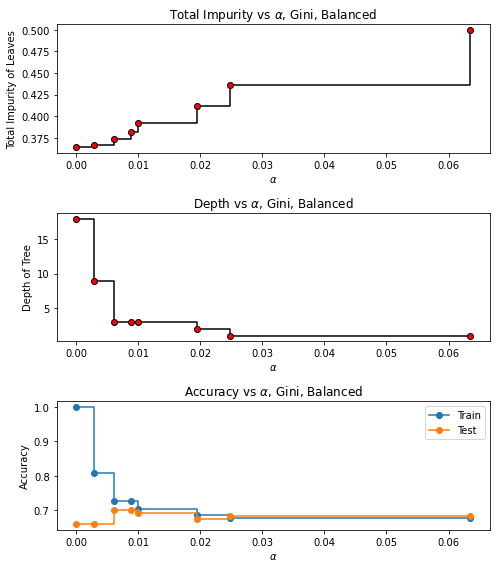

In [272]:
"""Full tree with pruning"""
mode = "Gini"
name_modifier = ", Balanced"#", Full Set of Covariates" #
bal = "balanced" # None
X_train, X_test, Y_train, Y_test = train_test_split(x, df.iloc[:,0], random_state=2)
entropy_tree = DecisionTreeClassifier(criterion=mode.lower(), max_depth=3)
et_path = entropy_tree.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = et_path.ccp_alphas, et_path.impurities
entropy_tree.fit(X_train, Y_train)

fig, ax = plt.subplots(3,1, figsize=(7,8))
ax[0].plot(ccp_alphas[:], impurities[:], marker='o', drawstyle="steps-post", markerfacecolor="r", color="k")
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Total Impurity of Leaves")
ax[0].set_title("Total Impurity vs "+ r'$\alpha$' +", " + mode + name_modifier)

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, criterion=mode.lower(), class_weight=bal)
    clf.fit(X_train, Y_train)
    clfs.append(clf)
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel("Depth of Tree")
ax[1].set_title("Depth vs " + r'$\alpha$' + ", " + mode + name_modifier)

train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

ax[2].set_xlabel(r'$\alpha$')
ax[2].set_ylabel("Accuracy")
ax[2].set_title("Accuracy vs " + r'$\alpha$' +", " + mode + name_modifier)
ax[2].plot(ccp_alphas, train_scores, marker='o', label="Train",
        drawstyle="steps-post")
ax[2].plot(ccp_alphas, test_scores, marker='o', label="Test",
        drawstyle="steps-post")
ax[2].legend()
fig.tight_layout()
plt.show()

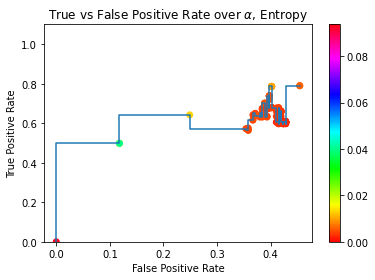

In [52]:
cm = []
weighted_bias = []
true_pos_corr = []
false_pos = []
fig, ax = plt.subplots()
df2 = None
colors = np.linspace(0,1,len(ccp_alphas))

for i in range(len(ccp_alphas)):
    cm.append(confusion_matrix(clfs[i].predict(X_test), Y_test))
    weighted_bias.append(((cm[i][1][0] + cm[i][1][1]) - (cm[i][0][1] + cm[i][1][1]))/((cm[i][0][1] + cm[i][1][1])))
    true_pos_corr.append(cm[i][1][1] / (cm[i][0][1] + cm[i][1][1]))
    false_pos.append(cm[i][1][0] / (cm[i][0][0] + cm[i][1][0]))
roc_tp=true_pos_corr
roc_fp=false_pos
d = {'fp': roc_fp, 'tp': roc_tp, 'c':ccp_alphas}
df2 = pd.DataFrame(data=d)
df2 = df2.sort_values(by=['fp'])
m = ax.scatter(df2['fp'], df2['tp'],c=df2['c'], cmap = plt.cm.get_cmap('hsv'))
ax.plot(df2['fp'], df2['tp'],drawstyle="steps-pre")
ax.set_ylim([0,1.1])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('True vs False Positive Rate over '+r'$\alpha$' + ', Entropy')
plt.colorbar(m)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix, Gini, $\\alpha$=0.06345183000512039')

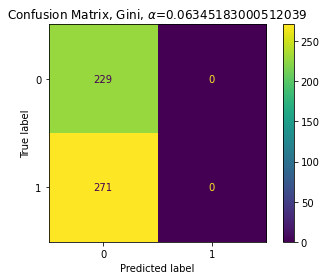

In [47]:
disp = plot_confusion_matrix(clfs[-1],X_test, Y_test)
disp.ax_.set_title("Confusion Matrix, "+mode+", " + r'$\alpha$' + '=' + str(ccp_alphas[-1]))

In [259]:
from pydotplus.graphviz import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(                           # Create dot data
    entropy_tree, filled=True, rounded=True,
    class_names=['nCAD','CAD'],
    feature_names=df.columns[1:],
    out_file=None
)

graph = graph_from_dot_data(dot_data) 
graph.write_png('full_gini_tree.png')                           # Write graph to PNG image

True

1


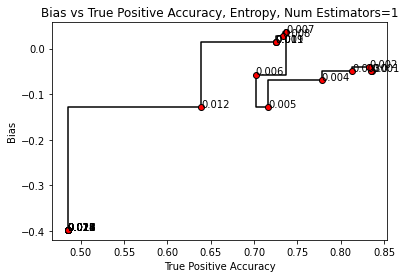

10


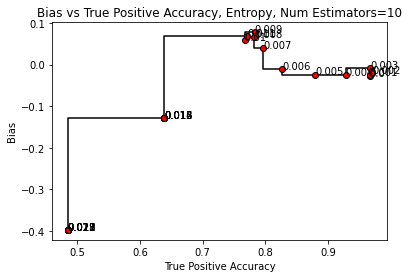

20


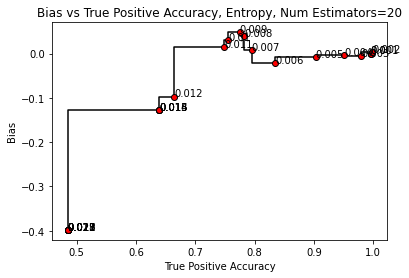

30


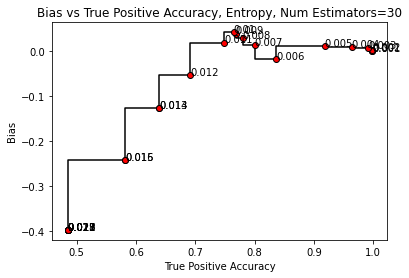

40


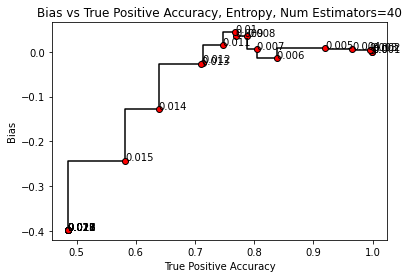

50


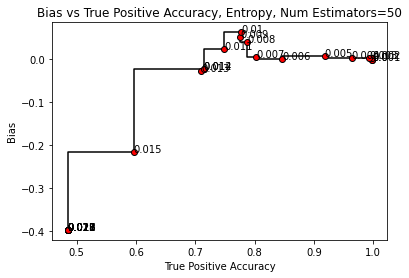

In [13]:
l = [k/1000 for k in range(0,24, 1)]
for i in [1,10,20,30,40,50]:
    bcm = []
    bweighted_bias = []
    btrue_pos_corr = []
    fig, ax = plt.subplots()
    print(i)
    for j in l:
        bt = DecisionTreeClassifier(random_state=0, max_features=None, ccp_alpha=j, criterion=mode.lower(), class_weight=bal)
        bag = BaggingClassifier(base_estimator=bt, n_estimators=i, max_samples=1.0, random_state=0)
        bag = bag.fit(x, df.iloc[:,0])
        bcm = confusion_matrix(bag.predict(x),  df.iloc[:,0] )
        bweighted_bias.append(((bcm[1][0] + bcm[1][1]) - (bcm[0][1] + bcm[1][1]))/((bcm[0][1] + bcm[1][1])))
        btrue_pos_corr.append(bcm[1][1] / (bcm[0][1] + bcm[1][1]))

    ax.plot(btrue_pos_corr,bweighted_bias,  marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
    ax.set_xlabel('True Positive Accuracy')
    ax.set_ylabel("Bias")
    ax.set_title("Bias vs True Positive Accuracy, " + mode + ', Num Estimators=' + str(i))
    ind = 0
    for el in l:
        plt.text(btrue_pos_corr[ind],bweighted_bias[ind], str(el))
        ind += 1
    plt.show()

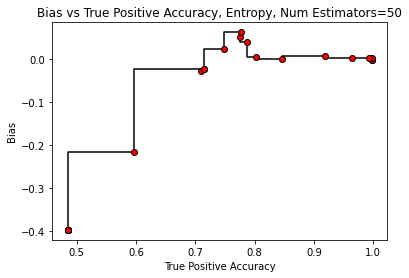

In [14]:
fig, ax = plt.subplots()
ax.plot(btrue_pos_corr,bweighted_bias,  marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
ax.set_xlabel('True Positive Accuracy')
ax.set_ylabel("Bias")
ax.set_title("Bias vs True Positive Accuracy, " + mode + ', Num Estimators=' + str(i))
plt.show()

1


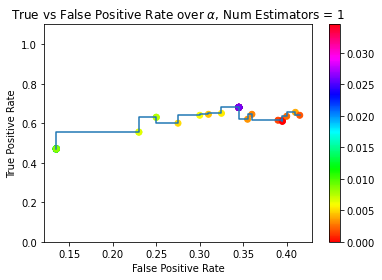

10


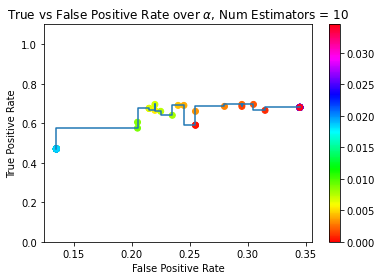

20


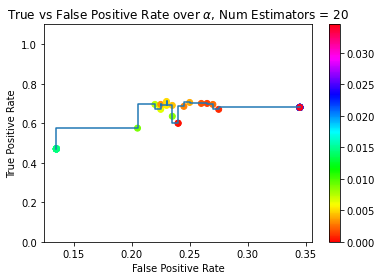

30


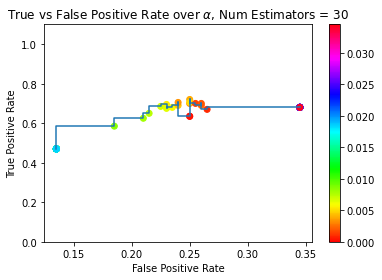

40


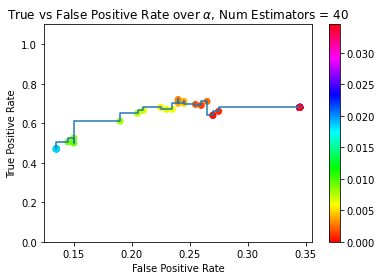

50


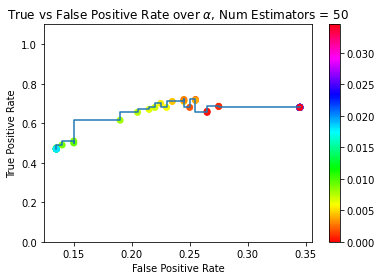

100


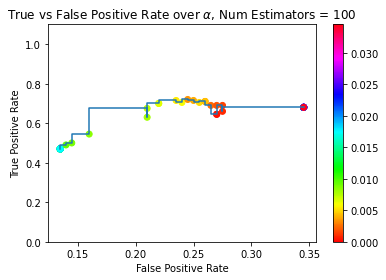

In [273]:
from sklearn.model_selection import train_test_split
trainingSet, testSet = train_test_split(df, test_size=0.2, random_state=0)

num_alpha = 70
colors = np.linspace(0,1,num_alpha)
l = [k/2000 for k in range(0,num_alpha, 1)]
roc_tp = []
roc_fp = []
for i in [1,10,20,30,40,50,100]:
    bcm = []
    bweighted_bias = []
    btrue_pos_corr = []
    bfalse_pos = []
    df2 = None
    fig, ax = plt.subplots()
    print(i)
    for j in l:
        bt = DecisionTreeClassifier(random_state=0, max_features=None, ccp_alpha=j, criterion=mode.lower(), class_weight=bal)
        bag = BaggingClassifier(base_estimator=bt, n_estimators=i, max_samples=1.0, random_state=0)
        bag = bag.fit(trainingSet.iloc[:,1:-1], trainingSet.iloc[:,0])
        bcm = confusion_matrix(bag.predict(testSet.iloc[:,1:-1]),  testSet.iloc[:,0] )
        bweighted_bias.append(((bcm[1][0] + bcm[1][1]) - (bcm[0][1] + bcm[1][1]))/((bcm[0][1] + bcm[1][1])))
        btrue_pos_corr.append(bcm[1][1] / (bcm[0][1] + bcm[1][1]))
        bfalse_pos.append(bcm[1][0] / (bcm[0][0] + bcm[1][0]))
    roc_tp=btrue_pos_corr
    roc_fp=bfalse_pos
    d = {'fp': roc_fp, 'tp': roc_tp, 'c':colors}
    df2 = pd.DataFrame(data=d)
    df2 = df2.sort_values(by=['fp'])
    m = ax.scatter(df2['fp'], df2['tp'],c=df2.index/2000, cmap = plt.cm.get_cmap('hsv'))
    ax.plot(df2['fp'], df2['tp'],drawstyle="steps-pre")
    ax.set_ylim([0,1.1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('True vs False Positive Rate over '+r'$\alpha$' + ', Num Estimators = ' + str(i))
    plt.colorbar(m)
    plt.show()

In [97]:
corr = df.corr()
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x','y','value']

In [274]:

def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize=(12,10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    m = ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size.abs()**.85 * size_scale, # Vector of square sizes, proportional to size parameter
        c=size,
        cmap=plt.cm.get_cmap('seismic'),
        vmin=-1,
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    #ax.set_title('Covariate Correlation Matrix', fontsize=20)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    v = np.linspace(-1, 1, 5, endpoint=True)
    n = plt.colorbar(m,ticks=v)

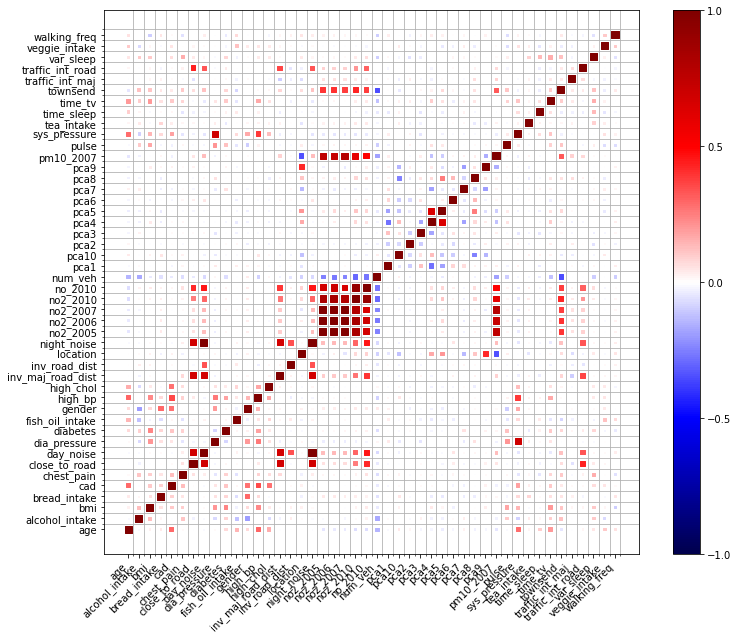

In [275]:
heatmap(x=corr['x'],y=corr['y'],size=corr['value'])


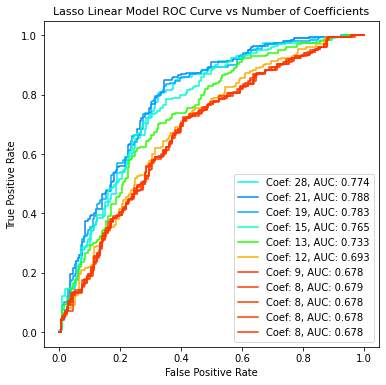

In [262]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, roc_auc_score, roc_curve


num_alpha = 11
alp = np.linspace(0, .1, num_alpha, endpoint=True)
r2_lasso = []
auc = []
lasso_fit = []
ind = 0

fig, ax = plt.subplots(figsize=(6,6))

for alpha in alp:
    lasso = Lasso(alpha, random_state=0)
    lasso_fit.append(lasso.fit(trainingSet.iloc[:,1:-1], trainingSet.iloc[:,0]))
    y_pred_lasso = lasso_fit[ind].predict(testSet.iloc[:,1:-1])
    r2_lasso.append(r2_score(testSet.iloc[:,0],y_pred_lasso))
    auc.append(roc_auc_score(testSet.iloc[:,0],y_pred_lasso))
    fpr, tpr, _ = roc_curve(testSet.iloc[:,0],y_pred_lasso)
    m = ax.plot(
        fpr, # Use mapping for x
        tpr, # Use mapping for y
        c= plt.cm.get_cmap('hsv')((auc[ind]-.67)*5),
        label='Coef: ' + str(sum(lasso_fit[ind].coef_ > 0)) + ', AUC: {:.3f}'.format(auc[ind]),
        linewidth=1.5,
    )
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Lasso Linear Model ROC Curve vs Number of Coefficients',fontsize=11)
    ind = ind + 1




0
1
2
3
4
5
6
7
8
9
10
11


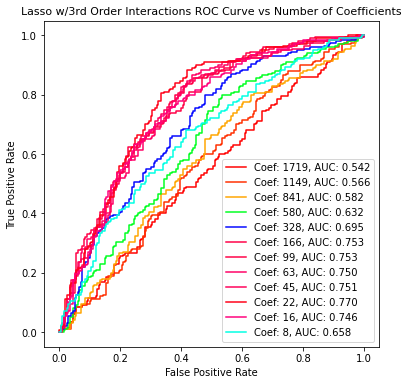

In [253]:
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
train_inter = interaction.fit_transform(trainingSet.iloc[:,1:-1])
test_inter = interaction.fit_transform(testSet.iloc[:,1:-1])

num_alpha = 12
coeff = np.linspace(0, 11, num_alpha, endpoint=True)
alp = 10 ** coeff
r2_lasso = []
auc = []
lasso_fit = []
ind = 0

fig, ax = plt.subplots(figsize=(6,6))

for alpha in alp:
    print(ind)
    lasso = Lasso(alpha, random_state=0)
    lasso_fit.append(lasso.fit(train_inter, trainingSet.iloc[:,0]))
    y_pred_lasso = lasso_fit[ind].predict(test_inter)
    r2_lasso.append(r2_score(testSet.iloc[:,0],y_pred_lasso))
    auc.append(roc_auc_score(testSet.iloc[:,0],y_pred_lasso))
    fpr, tpr, _ = roc_curve(testSet.iloc[:,0],y_pred_lasso)
    m = ax.plot(
        fpr, # Use mapping for x
        tpr, # Use mapping for y
        c= plt.cm.get_cmap('hsv')((auc[ind]-.56)*5),
        label='Coef: ' + str(sum(lasso_fit[ind].coef_ > 0)) + ', AUC: {:.3f}'.format(auc[ind]),
        linewidth=1.5,
    )
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Lasso w/3rd Order Interactions ROC Curve vs Number of Coefficients',fontsize=11)
    ind = ind + 1

In [249]:
coeff


array([      0.        ,  166666.66666667,  333333.33333333,
        500000.        ,  666666.66666667,  833333.33333333,
       1000000.        ])